# Import the Library

In [2]:
cd /home/near/deep_clustering/

/home/near/deep_clustering


In [35]:
import IPython.display as ipd
import os
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import audioread
import numpy as np
from scipy.io import loadmat, savemat
from scipy.io.wavfile import write
import scipy
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.autograd import Variable
from stft_utils import e_stft, e_istft
from feat_generator import get_one_hot
from separation import bss_eval_sources
from config import *

In [34]:
SDR = 0.0
SIR = 0.0
SAR = 0.0
max_sdr = 0
max_name = ''
f_list = glob.glob('/home/near/deep_clustering/evaluation_results_chimera/31_7957.16model/*.txt')
for ele in f_list:
    f = open(ele)
    for line in f:
        if 'SDR' in line:
            s1 = float(line.split()[1])
            s2 = float(line.split()[2])
            SDR+=s1
            SDR+=s2
            if max(s1,s2)>max_sdr:
                max_sdr = max(s1,s2)
                max_name = ele
        if 'SIR' in line:
            s1 = float(line.split()[1])
            s2 = float(line.split()[2])
            SIR+=s1
            SIR+=s2
        if 'SAR' in line:
            s1 = float(line.split()[1])
            s2 = float(line.split()[2])
            SAR+=s1
            SAR+=s2
print(SDR/(len(f_list)*2))
print(SIR/(len(f_list)*2))
print(SAR/(len(f_list)*2))
print(max_name)

6.6918105893333415
12.98341478566666
8.713468994666645
/home/near/deep_clustering/evaluation_results_chimera/31_7957.16model/443o0313_0.54779_053c0113_-0.54779.wav.txt


# Feature Generation

In [36]:
fn = '/scratch/near/2speakers/wav8k/min/cv/mix/014a010f_0.097107_20fa010l_-0.097107.wav'
sig, fs = librosa.load(fn,sr=8000)
n_sample = sig.shape[0]
stft = e_stft(sig,256,64,'hamming')
sig_recon = e_istft(stft, n_sample, 256,64,'hamming')
print(fs)
print(stft.shape)
print(n_sample)

8000
(129, 501)
31840


# Visualization of the label

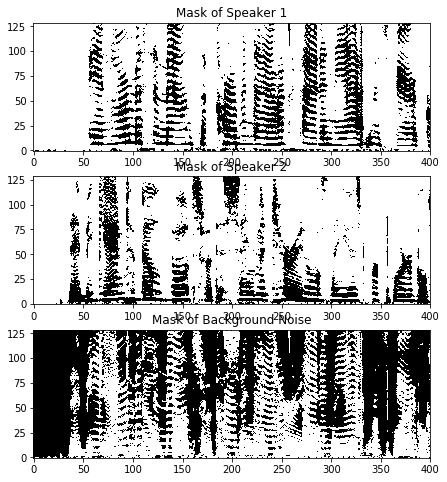

In [37]:
fn = '/scratch/near/2speakers/wav8k/min/cv/mix/014a010f_0.097107_20fa010l_-0.097107.wav'
label = get_one_hot(None,fn,400)
f, (ax1, ax2, ax3) = plt.subplots(3,figsize=(8,8))
ax1.imshow(label[:,:,0].T, cmap='binary', interpolation='nearest',origin='lower')
ax2.imshow(label[:,:,1].T, cmap='binary', interpolation='nearest',origin='lower')
ax3.imshow((1-label[:,:,1]-label[:,:,0]).T, cmap='binary', interpolation='nearest',origin='lower')
ax1.set_title("Mask of Speaker 1")
ax2.set_title("Mask of Speaker 2")
ax3.set_title("Mask of Background Noise")
plt.show()

# Test the Audio Quality Separated by Oracle Mask

In [38]:
enhance_oracle = e_istft(stft[:,:400]*label[:,:500,0].T,n_sample, 256,64,'hamming')
ipd.Audio(enhance_oracle,rate=8000) # load a local WAV file

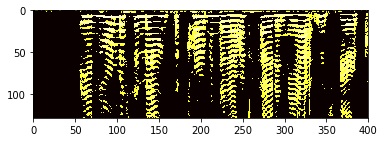

In [40]:
plt.imshow(np.log10(np.abs(stft[:,:400]*label[:,:,0].T)+1e-7), cmap='hot', interpolation='nearest')
plt.show()

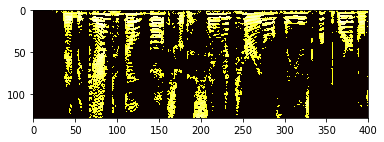

In [41]:
plt.imshow(np.log10(np.abs(stft[:,:400]*label[:,:,1].T)+1e-7), cmap='hot', interpolation='nearest')
plt.show()

# Load the trained model

In [42]:
m = torch.load('./chimera_models_400/DC_11_9349.56model')
m.cpu()
m2 = torch.load('./dc_models/55_14562310.00model') #the best deep clustering model
m2.cpu()

DCNet(
  (rnn): LSTM(129, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=5160, bias=True)
)

# Embedding of Chimera++ Model

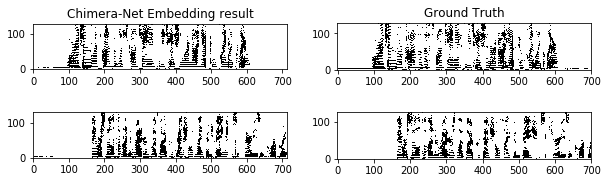

(array([10.77970071,  6.1776922 ]),
 array([17.57945574, 16.70013147]),
 array([11.87278934,  6.67278459]),
 array([1, 0]))

In [51]:
def get_test_stft(fn):
    sig, fs = librosa.load(fn,sr=8000)
    assert(fs==8000)
    stft = e_stft(sig,256,64,'hann')
    #stft = np.concatenate((stft,stft[:remain,:]),axis = 0)
    return stft.T

def get_test_normalize_feat(fn):
    sig, fs = librosa.load(fn,sr=8000)
    assert(fs==8000)
    # sig = sig-np.mean(sig)
    # sig = sig/(np.max(np.abs(sig))) +1e-7
    n_sample = sig.shape[0]
    stft = e_stft(sig,256,64,'hann')
    return np.log10(np.abs(np.transpose(stft))+1e-7)

fn = '/scratch/near/2speakers/wav8k/min/tt/mix/050a0509_2.4594_443o030b_-2.4594.wav'
b = get_test_normalize_feat(fn)
b = b.reshape(1,-1,129)
cuda = torch.device('cpu')
b = torch.tensor(b,dtype=torch.float,device=cuda)
c,_ = m(b)
c = c.cpu()
c = c.reshape(1,-1,129,20)
mask = torch.max(b)-2
d = c[b>mask]
d = d.detach().numpy()
kmeans = KMeans(n_clusters=2, random_state=0).fit(d)
f = kmeans.predict(d)
f1 = torch.zeros((b.shape),dtype=torch.int)
f2 = torch.zeros((b.shape),dtype=torch.int)
f1[b>mask] = torch.tensor(f,dtype=torch.int)
f2[b>mask] = torch.tensor(1-f,dtype=torch.int)
label = get_one_hot(None,fn,100)
f1 = f1.reshape(-1,129)
f2 = f2.reshape(-1,129)
f1 = f1.detach().numpy()
f2 = f2.detach().numpy()
_, ((ax1, gt1), (ax2, gt2) ) = plt.subplots(2,2,figsize=(10,3))
ax1.imshow(f2.T, cmap='binary', interpolation='nearest',origin='lower')
ax2.imshow(f1.T, cmap='binary', interpolation='nearest',origin='lower')
gt1.imshow(label[:,:,0].T, cmap='binary', interpolation='nearest',origin='lower')
gt2.imshow(label[:,:,1].T, cmap='binary', interpolation='nearest',origin='lower')
ax1.set_title("Chimera-Net Embedding result")
gt1.set_title("Ground Truth")
plt.show()
from separation import bss_eval_sources
fn_s1 = fn.replace('mix','s1')
fn_s2 = fn.replace('mix','s2')
s1, fs = librosa.load(fn_s1,sr=8000)
s2, fs = librosa.load(fn_s2,sr=8000)
stft = get_test_stft(fn)
stft_s2 = stft*f2
stft_s1 = stft*f1
enhanced_s1 = e_istft(stft_s1.T, s1.shape[0],256, 64, 'hamming')
enhanced_s2 = e_istft(stft_s2.T, s1.shape[0],256, 64, 'hamming')
bss_eval_sources(np.array([s1,s2]),np.array([enhanced_s1,enhanced_s2]))

In [52]:
ipd.Audio(enhanced_s1,rate=8000)

# Result of Best Deep Clustering Model

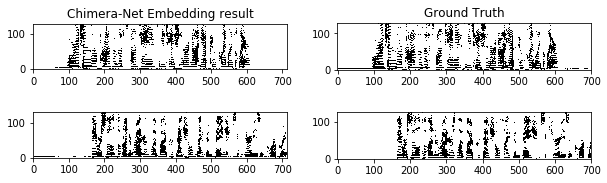

(array([11.73031458,  7.18807258]),
 array([19.37394327, 16.92532267]),
 array([12.60011326,  7.76312114]),
 array([0, 1]))

In [53]:
def get_test_stft(fn):
    sig, fs = librosa.load(fn,sr=8000)
    assert(fs==8000)
    stft = e_stft(sig,256,64,'hamming')
    #stft = np.concatenate((stft,stft[:remain,:]),axis = 0)
    return stft.T

def get_test_normalize_feat(fn):
    sig, fs = librosa.load(fn,sr=8000)
    assert(fs==8000)
    # sig = sig-np.mean(sig)
    # sig = sig/(np.max(np.abs(sig))) +1e-7
    n_sample = sig.shape[0]
    stft = e_stft(sig,256,64,'hamming')
    return np.log10(np.abs(np.transpose(stft))+1e-7)
b = get_test_normalize_feat(fn)
b = b.reshape(1,-1,129)
cuda = torch.device('cpu')
b = torch.tensor(b,dtype=torch.float,device=cuda)
c = m2(b)
c = c.cpu()
c = c.reshape(1,-1,129,40)
mask = torch.max(b)-2
d = c[b>mask]
d = d.detach().numpy()
kmeans = KMeans(n_clusters=2, random_state=0).fit(d)
f = kmeans.predict(d)
f1 = torch.zeros((b.shape),dtype=torch.int)
f2 = torch.zeros((b.shape),dtype=torch.int)
f1[b>mask] = torch.tensor(f,dtype=torch.int)
f2[b>mask] = torch.tensor(1-f,dtype=torch.int)
label = get_one_hot(None,fn,100)
f1 = f1.reshape(-1,129)
f2 = f2.reshape(-1,129)
f1 = f1.detach().numpy()
f2 = f2.detach().numpy()
_, ((ax1, gt1), (ax2, gt2) ) = plt.subplots(2,2,figsize=(10,3))
ax1.imshow(f1.T, cmap='binary', interpolation='nearest',origin='lower')
ax2.imshow(f2.T, cmap='binary', interpolation='nearest',origin='lower')
gt1.imshow(label[:,:,0].T, cmap='binary', interpolation='nearest',origin='lower')
gt2.imshow(label[:,:,1].T, cmap='binary', interpolation='nearest',origin='lower')
ax1.set_title("Chimera-Net Embedding result")
gt1.set_title("Ground Truth")
plt.show()
fn_s1 = fn.replace('mix','s1')
fn_s2 = fn.replace('mix','s2')
s1, fs = librosa.load(fn_s1,sr=8000)
s2, fs = librosa.load(fn_s2,sr=8000)
stft = get_test_stft(fn)
stft_s2 = stft*f2
stft_s1 = stft*f1
enhanced_s1 = e_istft(stft_s1.T, s1.shape[0],256, 64, 'hamming')
enhanced_s2 = e_istft(stft_s2.T, s1.shape[0],256, 64, 'hamming')
bss_eval_sources(np.array([s1,s2]),np.array([enhanced_s1,enhanced_s2]))

In [54]:
ipd.Audio(enhanced_s2,rate=8000) # load a local WAV file

# Mask of Chimera++ Model

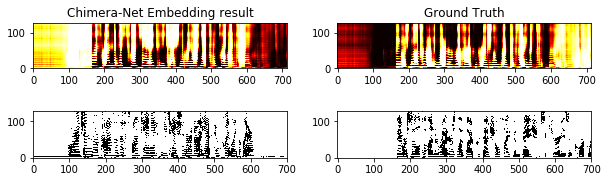

In [55]:
b = get_test_normalize_feat(fn)
stft = get_test_stft(fn)

silence_mask = np.log10(np.abs(stft)+1e-7) < np.max(np.log10(np.abs(stft)+1e-7))-2

b = b.reshape(1,-1,129)
cuda = torch.device('cpu')
b = torch.tensor(b,dtype=torch.float,device=cuda)
c, mask_pred = m(b)
mask_pred = mask_pred.detach().numpy()
f1 = mask_pred[0,:,:,0]
f2 = mask_pred[0,:,:,1]
# f1[silence_mask]=0.1
# f2[silence_mask]=0.1
label = get_one_hot(None,fn,100)
_, ((ax1, gt1), (ax2, gt2)) = plt.subplots(2,2,figsize=(10,3))
ax1.imshow(f1.T, cmap='hot', interpolation='nearest',origin='lower')
gt1.imshow(f2.T, cmap='hot', interpolation='nearest',origin='lower')
ax2.imshow(label[:,:,0].T, cmap='binary', interpolation='nearest',origin='lower')
gt2.imshow(label[:,:,1].T, cmap='binary', interpolation='nearest',origin='lower')
ax1.set_title("Chimera-Net Embedding result")
gt1.set_title("Ground Truth")
plt.show()

In [56]:
stft_s2 = stft*f2
stft_s1 = stft*f1
enhanced_s1 = e_istft(stft_s1.T, s1.shape[0],256, 64, 'hann')
enhanced_s2 = e_istft(stft_s2.T, s1.shape[0],256, 64, 'hann')
bss_eval_sources(np.array([s1,s2]),np.array([enhanced_s1,enhanced_s2]))

(array([11.41106025,  6.90267071]),
 array([16.89053051, 15.76600344]),
 array([12.94488932,  7.62069424]),
 array([0, 1]))

In [57]:
ipd.Audio(enhanced_s2,rate=8000)